# TAREA

Paso 1: Importar librerias


In [2]:
!pip3 install mesa

In [68]:
from mesa import Agent, Model 
from mesa.space import MultiGrid
from mesa.time import SimultaneousActivation
from mesa.datacollection import DataCollector


%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"
matplotlib.rcParams['animation.embed_limit'] = 2**128


import numpy as np
import pandas as pd

import random
import time
import datetime

Paso 2: Crear el Grid

In [124]:
def get_grid(model):
  grid = np.zeros((model.grid.width, model.grid.height))
  for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    for contenido in cell_content:
      if isinstance(contenido, Vacuum):
        grid[x][y] = 2
      else:
        grid[x][y] = contenido.live
  return grid

class Vacuum(Agent):
  def __init__(self, unique_id, model):
    super().__init__(unique_id, model)
    self.live = 2

  def move(self):
    possible_steps = self.model.grid.get_neighborhood(self.pos, moore=True, include_center=False)
    new_position = self.random.choice(possible_steps)
    self.model.grid.move_agent(self, new_position)

  def limpia(self):
    cellmates = self.model.grid.get_cell_list_contents([self.pos])
    for i in cellmates:
      if type(i) == LimpioOSucio:
        if i.live == 1:
          i.next_state = 0
        else:
          self.move()

  def step(self):
    self.limpia()

class LimpioOSucio(Agent):
  def __init__(self, unique_id, model, LoS):
    super().__init__(unique_id, model)
    self.live = LoS
    self.next_state = None

  def step(self):
    self.next_state = self.live

  def advance(self):
    self.live = self.next_state

class HabitacionModel(Model):
  def __init__(self, width, height, numVacuum, porcentajeTilesSucias):
    self.num_agents = width * height
    self.grid = MultiGrid(width, height, True)
    self.schedule = SimultaneousActivation(self)
    self.numTilesLimpias = 0
    self.numTilesSucias = 0
    self.TilesSucias = float(int(self.num_agents * (porcentajeTilesSucias/100)))
    self.TilesLimpias = self.num_agents - self.TilesSucias

    for (content, x, y) in self.grid.coord_iter():
      LoS = np.random.choice([0,1])
      if LoS == 0:
        if self.TilesLimpias > 0:
          a = LimpioOSucio((x, y), self, 0)
          self.TilesLimpias -= 1
        else: 
          a = LimpioOSucio((x, y), self, 1)
          self.TilesSucias -= 1
      else:
        if self.TilesSucias > 0:
          a = LimpioOSucio((x, y), self, 1)
          self.TilesSucias -= 1
        else:
          a = LimpioOSucio((x, y), self, 0)
          self.TilesLimpias -= 1

      self.grid.place_agent(a, (x, y))
      self.schedule.add(a)

    for i in range(numVacuum):
      a = Vacuum(i, self)
      self.schedule.add(a)
      self.grid.place_agent(a, (0, 0))
    
    self.datacollector = DataCollector(model_reporters={"Grid": get_grid})

  def step(self):
    self.datacollector.collect(self)
    self.schedule.step()

In [133]:
model = HabitacionModel(15, 10, 25, 70)
for i in range(50):
  model.step()

In [134]:
all_grid = model.datacollector.get_model_vars_dataframe()

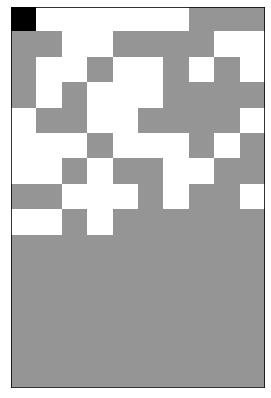

In [135]:
fig, axs = plt.subplots(figsize=(7,7))
axs.set_xticks([])
axs.set_yticks([])
patch = plt.imshow(all_grid.iloc[0][0], cmap='Greys')

def animate(i):
    patch.set_data(all_grid.iloc[i][0])
    
anim = animation.FuncAnimation(fig, animate, frames=50)

In [136]:
anim

Relfexiones & Conclusiones

El desarrollo de este trabajo fue supremamente dificil por la falta de herramientas que tuve para el aprendizaje de este Framework. De todas maneras, logré acercarme a el output esperado por el problema. 

Entre más agentes aspiradora tiene el modelo, menos tiempo tardará el programa en ejecutarse. Esto se debe a que habrán mas aspiradoras en el mismo cuarto cambiando de celda simultaneamente. Si la cantidad de aspiradoras es la misma que la cantidad de celdas en el grid, el programa culmina casi que inmediatamente. Sucede exactamente lo mismo con la cantidad de pasos que requiere el programa para limpiar todas las celdas, ya que, como en el punto anterior se mencionó, hay más aspiradoras que pueden cumplir con la labor de recorrer y limpiar las celdas. 